# COVID-19 Literature Clustering

In [1]:
from IPython.display import Image
#Image(filename='/kaggle/input/screen-shot/screen_shot.png', width=800) 

##### You can find the full version of the interactive plot here on GitHub: 
https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html <br>
Because of its size, I can only put the smaller version on this Notebook.

### Goal
Given the large number of literature and the rapid spread of COVID-19, it is difficult for health professionals to keep up with new information on the virus. Can we cluster similar research articles together to find related information? Clustering can be used to create a tool to identify similar articles, given a target article. It can also reduce the number of articles one has to go through as one can focus on a cluster of articles rather than all. In this notebook, we will to attempt narrow down the stream of information coming out about COVID-19.

### Table of Contents
1. Loading the data
2. Pre-processing
3. 

# Loading the Data
Load the data following the notebook by Ivan Ega Pratama, from Kaggle.
#### Cite: [Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

### Loading Metadata

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [3]:
root_path = 'data/CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license
1,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,custom_license
2,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,custom_license
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,custom_license
4,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,custom_license


In [4]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44220 entries, 0 to 44219
Data columns (total 15 columns):
sha                            28462 non-null object
source_x                       44220 non-null object
title                          43996 non-null object
doi                            40750 non-null object
pmcid                          23319 non-null object
pubmed_id                      22943 non-null object
license                        44220 non-null object
abstract                       35806 non-null object
publish_time                   34197 non-null object
authors                        41074 non-null object
journal                        33173 non-null object
Microsoft Academic Paper ID    964 non-null object
WHO #Covidence                 1767 non-null object
has_full_text                  44220 non-null bool
full_text_file                 32829 non-null object
dtypes: bool(1), object(14)
memory usage: 4.8+ MB


### Fetch All of JSON File Path

Get path to all JSON files:

In [5]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

29315

### Helper Functions

 File Reader Class

In [6]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

0015023cc06b5362d332b3baf348d11567ca2fbb: word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a si... VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structura...


Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.

In [7]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Load the Data into DataFrame

Using the helper functions, let's read in the articles into a DataFrame that can be used easily:

In [8]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 29315
Processing index: 2931 of 29315
Processing index: 5862 of 29315
Processing index: 8793 of 29315
Processing index: 11724 of 29315
Processing index: 14655 of 29315
Processing index: 17586 of 29315
Processing index: 20517 of 29315
Processing index: 23448 of 29315
Processing index: 26379 of 29315
Processing index: 29310 of 29315


,paper_id,abstract,body_text,authors,title,journal,abstract_summary
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...","Ward, J. C. J.. Lasecka-Dykes, L....",The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...","Butt, S. L.. Erwood, E. C....","Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...
3,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,A Combined Evidence Approach to Prioritize<br...,NaN,Nipah Virus (NiV) came into limelight recentl...
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch...,Assessing spread risk of Wuhan novel<br>coron...,NaN,Background: A novel coronavirus (2019-nCoV)<b...


<br>

## Some feature engineering

Adding word count columns for both abstract and body_text can be useful parameters later:

In [9]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid['body_num_char']=df_covid['body_text'].apply(lambda x:len(str(x))) # character count in body
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,num_char
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...","Ward, J. C. J.. Lasecka-Dykes, L....",The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...,241,1728,705,11205
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.,0,755,377,4989
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...","Butt, S. L.. Erwood, E. C....","Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...,1647,4003,1185,25935
3,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,A Combined Evidence Approach to Prioritize<br...,NaN,Nipah Virus (NiV) came into limelight recentl...,326,2399,1026,15754
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch...,Assessing spread risk of Wuhan novel<br>coron...,NaN,Background: A novel coronavirus (2019-nCoV)<b...,22,4642,1190,29825


In [10]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27678 entries, 0 to 27677
Data columns (total 11 columns):
paper_id               27678 non-null object
abstract               27678 non-null object
body_text              27678 non-null object
authors                26929 non-null object
title                  27634 non-null object
journal                26784 non-null object
abstract_summary       27678 non-null object
abstract_word_count    27678 non-null int64
body_word_count        27678 non-null int64
body_unique_words      27678 non-null int64
num_char               27678 non-null int64
dtypes: int64(4), object(7)
memory usage: 2.3+ MB


In [11]:
df_covid['abstract'].describe(include='all')

count     27678
unique    20191
top            
freq       7453
Name: abstract, dtype: object

## Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

(Thank you Desmond Yeoh for recommending the below approach on Kaggle)

In [12]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     27663
unique    20191
top            
freq       7444
Name: abstract, dtype: object

In [13]:
df_covid['body_text'].describe(include='all')

count                                                 27663
unique                                                27662
top       In a global world, knowledge of imported infec...
freq                                                      2
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

In [54]:
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,num_char,num_of_stopwords
885,00142f93c18b07350be89e96372d240372437ed9,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...,"Geginat, Jens. Nizzoli, Giulia...",Immunity to Pathogens Taught by Specialized<b...,Front Immunol,Dendritic cells (DCs) are specialized<br>anti...,309,5305,1522,33353,1746
886,0022796bb2112abd2e6423ba2d57751db06049fb,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...,"Viennet, Elvina. Ritchie, Scott A....",Public Health Responses to and Challenges for...,PLoS Negl Trop Dis,Dengue has a negative impact in low-and lower...,276,7288,2560,47794,2381
887,00326efcca0852dc6e39dc6b7786267e1bc4f194,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...,"Turner, Erin L.. Nielsen, Katie R....",A Review of Pediatric Critical Care in<br>Res...,Front Pediatr,"Fifteen years ago, United Nations world<br>le...",151,7593,2440,51335,2667
888,00352a58c8766861effed18a4b079d1683fec2ec,Posttranslational modification of proteins by ...,Ubiquitination is a widely used posttranslatio...,"Hodul, Molly. Dahlberg, Caroline L....",Function of the Deubiquitinating Enzyme USP46...,Front Synaptic Neurosci,Posttranslational modification of proteins<br...,148,3156,1068,20441,938
889,0043d044273b8eb1585d3a66061e9b4e03edc062,Background: Tuberculosis is a devastating dise...,The Ministry of Health of the People's Republi...,"Yang, Yu Rong. McManus, Donald P...",Evaluation of the tuberculosis programme in<b...,BMC Public Health,Background: Tuberculosis is a devastating<br>...,264,3178,1074,19640,1229


In [55]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words,num_char,num_of_stopwords
count,26044.000000,26044.000000,26044.000000,2.604400e+04,26044.000000
mean,163.873061,4727.664952,1445.868300,3.066333e+04,1623.898403
std,156.632005,5395.844909,967.492081,3.582666e+04,1908.325205
min,0.000000,13.000000,13.000000,7.000000e+01,0.000000
25%,0.000000,2596.000000,965.000000,1.673300e+04,875.000000
50%,164.000000,3817.000000,1282.000000,2.460200e+04,1308.000000
75%,240.000000,5550.000000,1698.250000,3.582550e+04,1906.000000
max,3694.000000,232431.000000,30523.000000,1.549213e+06,79208.000000


# Data Pre-processing

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [56]:
df_covid.dropna(inplace=True)
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26044 entries, 885 to 27677
Data columns (total 12 columns):
paper_id               26044 non-null object
abstract               26044 non-null object
body_text              26044 non-null object
authors                26044 non-null object
title                  26044 non-null object
journal                26044 non-null object
abstract_summary       26044 non-null object
abstract_word_count    26044 non-null int64
body_word_count        26044 non-null int64
body_unique_words      26044 non-null int64
num_char               26044 non-null int64
num_of_stopwords       26044 non-null int64
dtypes: int64(5), object(7)
memory usage: 2.6+ MB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [57]:
## Filter by language
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df_covid.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|███████████████████████████████████████████████████████████████████████████| 26044/26044 [01:48<00:00, 240.68it/s]


Lets take a look at the language distribution in the dataset

In [62]:
unique_languages = 0
for lang in set(languages):
    print(lang, ":" ,languages.count(lang))
    unique_languages += 1

print("\nTotal:", len(languages))


it : 13
en : 25424
es : 259
pt : 12
af : 1
ca : 1
cy : 1
de : 34
zh-cn : 1
fr : 296
pl : 2

Total: 26044


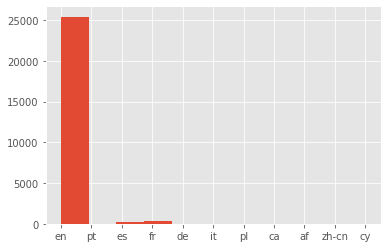

In [66]:
df_covid['language'] = languages
df_covid['language'].hist(bins=unique_languages)

For now we will drop any language that is not English. It may be worthwhile to translate these texts in the future

In [ ]:
df_covid = df_covid[df_covid['language'] == 'en'] 
df_covid.info()

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the nltk library. This function will convert text to lower case, remove punctuation, and find and remove stopwords (common words that will act as noise in the clustering step). The function can also try to determine the rootword of each token. This behavior is controlled by the stem boolean.

In [ ]:
df_covid.head()import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
import string

def process_text(text, stem=True, delimiter=' '):
    
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()] 
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    if stem:
        stemmer = nltk.stem.PorterStemmer()
        words = [stemmer.stem(w) for w in words]
 
    processed = "".join([delimiter + i for i in words]).strip()
    return processed

In [51]:
df_covid['processed_body'] = df_sample.apply(lambda x: process_text(x['body_text'], stem=False), axis=1)
df_covid['processed_abstract'] = df_sample.apply(lambda x: process_text(x['abstract_text'], stem=False), axis=1)

### Let's add another feature that counts stopwords in the body

In [17]:
STOP_WORDS = set(stopwords.words('english'))
df_covid['num_of_stopwords']=df_covid['body_text'].apply(lambda x:len([ w for w in str(x).lower().split() if w in STOP_WORDS]))

[nltk_data] Downloading package stopwords to C:\Users\Nick
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
import seaborn as sns

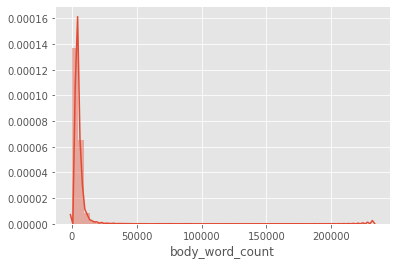

In [67]:
sns.distplot(df_covid['body_word_count'])

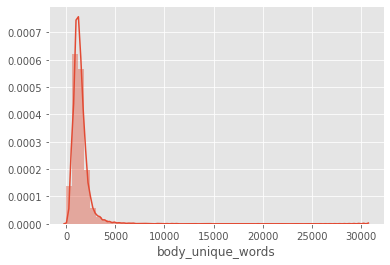

In [69]:
sns.distplot(df_covid['body_unique_words'])